In [1]:
import pickle
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from scipy.signal import detrend
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

# Data Processing 

In [2]:
sales_data = pd.read_csv('Data/sales dataset.csv')
sales_data['salesDate'] = pd.to_datetime(sales_data['salesDate'], infer_datetime_format=True)
selected_columns1 =['salesAmount', 'salesDate']
sales_data = sales_data[selected_columns1]
##########################################################################
expenses_data = pd.read_csv('Data/expenses dataset.csv')
expenses_data['expenseDate'] = pd.to_datetime(expenses_data['expenseDate'], infer_datetime_format=True)
selected_columns =['expenseAmount', 'expenseDate']
expenses_data = expenses_data[selected_columns]
##########################################################################
print('Shape of expenses data', expenses_data.shape)
print('Shape of sales data', sales_data.shape)
sales_data

Shape of expenses data (6622, 2)
Shape of sales data (89245, 2)


,salesAmount,salesDate
0,1200,2020-10-27
1,100,2020-10-27
2,6900,2020-10-27
3,1800,2020-10-27
4,400,2020-10-27
...,...,...
89240,18450,2023-11-10
89241,4000,2023-11-10
89242,2000,2023-11-10
89243,2600,2023-11-10


In [3]:
# The function groups either the expense or sales data into the monthly series
# But the first column must be the amount and the second column must be the dates in datetime format
def groupMonth(df):
    df['Year'] = df.iloc[:,1].dt.year
    df['Month'] = df.iloc[:,1].dt.month
    df['Amount'] = df.iloc[:,0]
    monthly = df.groupby(['Year','Month'])['Amount'].sum().reset_index()
    return monthly

# The function groups either the expense or sales data into the daily series
# But the first column must be the amount and the second column must be the dates in datetime format
def groupDay(df):
    df['Year'] = df.iloc[:,1].dt.year
    df['Month'] = df.iloc[:,1].dt.month
    df['Day'] = df.iloc[:,1].dt.day
    df['Amount'] = df.iloc[:,0]
    daily = df.groupby(['Year','Month','Day'])['Amount'].sum().reset_index()
    return daily

def monthlyToSingleDate(df, Year, Month):
    df['date'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month'].astype(str))
    df = df.drop(['Year','Month',], axis=1)
    df = df.set_index('date')
    return df

def dailyToSingleDate(df,Year, Month, Day):
        df['date'] = pd.to_datetime(df[['Year','Month','Day']])
        df = df.drop(['Year','Month','Day'], axis=1)
        df = df.set_index('date')
        return df

In [4]:
sd = groupDay(sales_data)
ed = groupDay(expenses_data)
em = groupMonth(expenses_data)
sm = groupMonth(sales_data)

daily_sales = dailyToSingleDate(sd, sd['Year'], sd['Month'], sd['Day'])
daily_expenses = dailyToSingleDate(ed, ed['Year'], ed['Month'], ed['Day'])
monthly_expenses = monthlyToSingleDate(em, em['Year'], em['Month'])
monthly_sales = monthlyToSingleDate(sm, sm['Year'], sm['Month'])

In [5]:
dailySales = daily_sales[705:]    #705 for the removal of irrelevant data points
dailyExpenses = daily_expenses[890:]  #890 for the removal of irrelevant data points
monthlySales = monthly_sales
monthlyExpenses = monthly_expenses

In [6]:
print(len(monthlyExpenses), len(monthlySales))
print(len(dailyExpenses), len(dailySales))

43 38
182 236


In [7]:
category1 = dailySales
category2 = dailyExpenses
category3 = monthlySales
category4 = monthlyExpenses
category = category2
category

,Amount
date,
2023-04-11,81700.0
2023-04-12,125150.0
2023-04-13,42825.0
2023-04-14,44300.0
2023-04-15,13500.0
...,...
2023-11-04,95800.0
2023-11-06,202000.0
2023-11-07,27101.0


# Remove Outliers

In [8]:
def remove_outliers_zscore(data, threshold=4):
    z_scores = np.abs((data - np.mean(data)) / np.std(data))
    filtered_data = data[(z_scores < threshold)]
    return filtered_data

filteredCategory = remove_outliers_zscore(category)
category = filteredCategory
category = category.tail(30)

C:\Users\Berlin\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


In [9]:
category.reset_index(inplace=True)
category = pd.DataFrame(category['Amount'])
Category = category

In [10]:
# plt.figure(figsize=(10,6))
# plt.plot(category)
# plt.title('Daily Sales Data')
# plt.xlabel('Date')
# plt.ylabel('Sales')
# plt.show()

# Adding Lagged Variables

In [11]:
lags = [1,2,3]
for lag in lags:
    category[f'lag{lag}'] = category['Amount'].shift(lag)
category.dropna(inplace=True)
selected_columns = ['Amount', 'lag1', 'lag2', 'lag3']
category = category[selected_columns]
category

,Amount,lag1,lag2,lag3
3,22500.0,50800.0,25900.0,18000.0
4,182150.0,22500.0,50800.0,25900.0
5,59100.0,182150.0,22500.0,50800.0
6,108100.0,59100.0,182150.0,22500.0
7,88900.0,108100.0,59100.0,182150.0
8,115500.0,88900.0,108100.0,59100.0
9,90500.0,115500.0,88900.0,108100.0
10,351180.0,90500.0,115500.0,88900.0
11,237900.0,351180.0,90500.0,115500.0
12,63250.0,237900.0,351180.0,90500.0


# Train - Test Split

In [12]:
X = category.drop(category.columns[0], axis=1)
y = category.iloc[:,0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Fit the model

In [13]:
from sklearn.ensemble import RandomForestRegressor

rf_regressor = RandomForestRegressor(n_estimators=200, random_state=42)
rf_regressor.fit(X_train, y_train)

RandomForestRegressor(n_estimators=200, random_state=42)

In [14]:
# with open('dailySales.pk1', 'wb') as f:
#     pickle.dump(rf_regressor, f)

In [15]:
# with open('dailyExpenses.pk1', 'wb') as f:
#     pickle.dump(model2, f)
# result = model2.fit()
# print(result.summary())

In [16]:
# with open('monthlyExpenses.pk1', 'wb') as f:
#     pickle.dump(rf_regressor, f)
# Takes 3 target lags

# Make Time Series Predictions

In [17]:
X_test

,lag1,lag2,lag3
24,25800.0,17000.0,84800.0
25,2500.0,25800.0,17000.0
26,95800.0,2500.0,25800.0
27,202000.0,95800.0,2500.0
28,27101.0,202000.0,95800.0
29,61750.0,27101.0,202000.0


In [19]:
y_pred = rf_regressor.predict(X_test)

In [20]:
y_pred

array([130889.15, 141946.75,  93238.8 ,  81961.55, 106345.55,  86750.  ])

# Evaluate Model

In [21]:
mse = mean_squared_error(y_test, y_pred)
rmse =  np.sqrt(mean_squared_error(y_test, y_pred))

print(f'Mean Squared Error : {mse}')
print(f'Root Mean Squared Error : {rmse}')

Mean Squared Error : 6404560087.471665
Root Mean Squared Error : 80028.49547174847


In [22]:
category = pd.DataFrame(category2)
category.reset_index(inplace=True)
category =category['Amount']

index_start = 24
index = range(index_start, index_start + len(y_pred))
df = pd.DataFrame(y_pred, index=index, columns=['Values'])

<function matplotlib.pyplot.xlabel(xlabel, fontdict=None, labelpad=None, *, loc=None, **kwargs)>

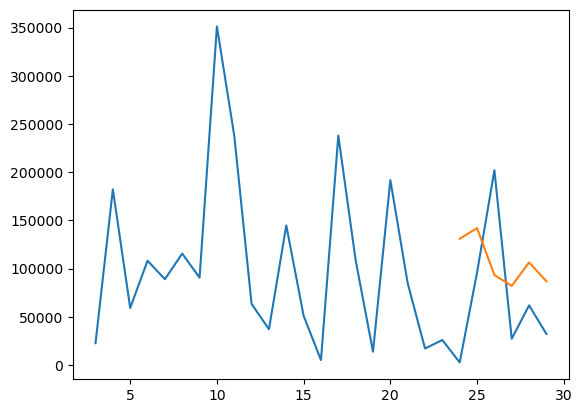

In [23]:
plt.plot(Category['Amount'], label='Original Data')
plt.plot(df)
plt.xlabel

In [166]:
data = {
    'lag1': [1546350.0],
    'lag2': [1148263.0],
    'lag3': [1050750.0],
#     'lag4': [1148263.0],
#     'lag5': [1327412.0]
}

df = pd.DataFrame(data)
predict = rf_regressor.predict(df)
# predict = predict.reshape(-1, 1)
# predict = scaler.inverse_transform(predict)
predict

C:\Users\Berlin\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


array([109167.])